In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import RepeatVector
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
# fix random seed for reproducibility
tf.random.set_seed(8)

Num GPUs Available:  1


In [35]:
# Global param
FOLDER_LOCATION = "Model/Data_for_ML_TT-DB"
# Hyperparameter
TRAIN_TEST_RATIO = 0.7
TIME_STEP = 2
MODEL_TYPE = "CNN_LSTM_DNN2"
EPOCH_SIZE = 1000
BATCH_SIZE = 4
FEATURE_NUMBER = 3
MODEL_JSON = {}
def to_string():
    print_list = [
        f"Time step: {TIME_STEP}",
        f"Ratio: {TRAIN_TEST_RATIO}",
        f"Model type: {MODEL_TYPE}",
        f"Epoch size: {EPOCH_SIZE}",
        f"Batch size: {BATCH_SIZE}",
        f"Model json: {MODEL_JSON}",
    ]
    return "\n".join(print_list)

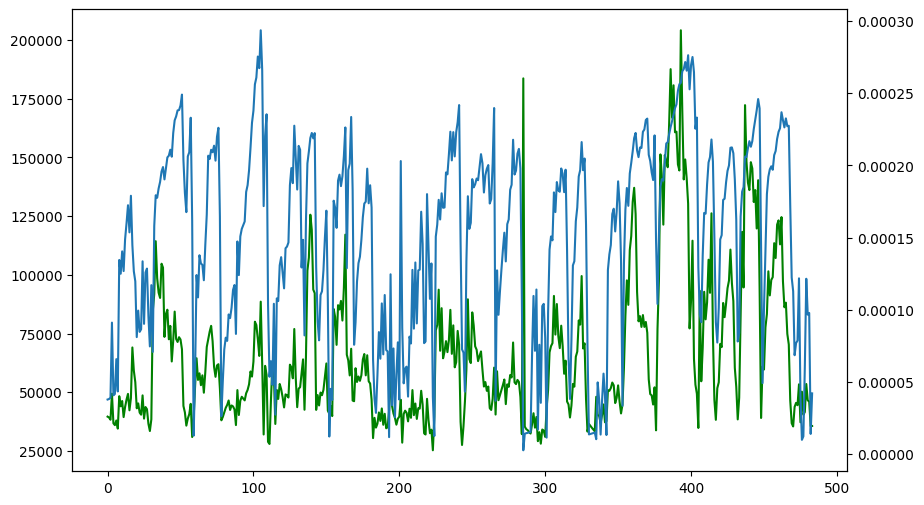

In [36]:
dataframe = pd.read_excel('Data/Data_for_ML_TT-DB.xlsx', sheet_name="Sheet1", header=1, usecols=[0,1,2])
dataset = dataframe.values
# dataset = np.reshape(dataset, (-1, 3))

#Preprocessing
for i in range(dataset.shape[0]):
    dataset[i][0] = int(dataset[i][0][3:5])
# dataset[np.isnan(dataset)] = 0

dataset = dataset.astype('float64')
# plt.clf()
plt.figure(figsize=(10,6))
plt.plot(dataset[:,1], color="green")
plt.twinx()
plt.plot(dataset[:,2])
plt.rcParams.update({'font.size': 10})
plt.show()

Normalize the dataset, when working with sigmoid or tanh function as activation function, normalize data to range 0, 1

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler_y = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

In [38]:
# split into train and test sets
train_size = int(len(dataset) * TRAIN_TEST_RATIO)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

338 146


In [39]:
# pca = PCA(n_components = 2)
# FEATURE_NUMBER = 2
# print(train.shape)
# train_x = pca.fit_transform(train)
# test_x = pca.transform(test)
# print(train_x.shape)
# print(test_x.shape)
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

In [40]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, y_col=0):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, y_col])
	return np.array(dataX), np.array(dataY)

In [41]:
# reshape into X=t and Y=t+1
# train_x, train_y = create_dataset(train, TIME_STEP)
# test_x, test_y = create_dataset(test, TIME_STEP)
train_x = scaler.fit_transform(train)
test_x = scaler.transform(test)
train_x, _ = create_dataset(train_x, TIME_STEP)
test_x, _ = create_dataset(test_x, TIME_STEP)
_, train_y = create_dataset(train, TIME_STEP,2)
_, test_y = create_dataset(test, TIME_STEP,2)
train_y = scaler.fit_transform(train_y.reshape(-1,1))
test_y = scaler.transform(test_y.reshape(-1,1))
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(335, 2, 3)
(335, 1)
(143, 2, 3)
(143, 1)


In [42]:
# reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], TIME_STEP, FEATURE_NUMBER))
test_x = np.reshape(test_x, (test_x.shape[0], TIME_STEP, FEATURE_NUMBER))
print(train_x.shape)
print(test_x.shape)


(335, 2, 3)
(143, 2, 3)


In [43]:
# create and fit the LSTM network
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.00001,
    # patience=int(EPOCH_SIZE*0.02),
    patience=int(15),
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
cnn1d_64_2 = Conv1D(
    64,
    (2),
    activation="relu",
    input_shape=(TIME_STEP, FEATURE_NUMBER),
    name="cnn1d_64_2",
)
lstm_32_sequences = LSTM(
    32,
    "relu",
    input_shape=(TIME_STEP, FEATURE_NUMBER),
    return_sequences=True,
    name="lstm_32_sequences",
)
lstm_32 = LSTM(
    32,
    "relu",
    input_shape=(TIME_STEP, FEATURE_NUMBER),
    name="lstm_32",
)
dense_16 = Dense(16,name="dense_16")
dense_8 = Dense(8,name="dense_8")
dense_1 = Dense(1,name="dense_1")
model = Sequential()
if MODEL_TYPE == "LSTM":
    model.add(LSTM(32, input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True))
    model.add(LSTM(32, input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN":
    model.add(
        Conv1D(32, (3), activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    # model.add(layers.MaxPooling1D((2)))
    model.add(Conv1D(64, (3), activation="relu"))
    # model.add(layers.MaxPooling1D((2)))
    model.add(Conv1D(64, (3), activation="relu"))
    model.add(MaxPooling1D((2)))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM":
    model.add(Conv1D(6, (3), activation="relu", input_shape=(TIME_STEP, 1)))
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(1))
elif MODEL_TYPE == "CNN_LSTM_DNN":
    model.add(cnn1d_64_2)
    model.add(lstm_32_sequences)
    model.add(lstm_32)
    model.add(dense_16)
    model.add(dense_8)
    model.add(dense_1)
elif MODEL_TYPE == "CNN_LSTM_DNN2":
    model.add(
        Conv1D(128, (2), activation="relu", input_shape=(TIME_STEP, FEATURE_NUMBER))
    )
    model.add(
        LSTM(
            200, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True
        )
    )
    model.add(LSTM(100, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN":
    model.add(
        LSTM(32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True)
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER), return_sequences=True)
    )
    model.add(LSTM(32, "relu", input_shape=(TIME_STEP, FEATURE_NUMBER)))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN2":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(16))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN3":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1), return_sequences=True))
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(32))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN4":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(32))
    model.add(Dense(1))
elif MODEL_TYPE == "LSTM_DNN5":
    model.add(LSTM(300, "relu", input_shape=(TIME_STEP, 1)))
    model.add(Dense(1))
model.summary()
MODEL_JSON = model.to_json()
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(
    train_x,
    train_y,
    epochs=EPOCH_SIZE,
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=[early_stopping, tensorboard_callback],
)
# %tensorboard --logdir logs/fit

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 128)            896       
                                                                 
 lstm_2 (LSTM)               (None, 1, 200)            263200    
                                                                 
 lstm_3 (LSTM)               (None, 100)               120400    
                                                                 
 dense_3 (Dense)             (None, 16)                1616      
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 386,257
Trainable params: 386,257
Non-tr

In [44]:
# save model
version = 0
for dir in os.scandir(f"./{FOLDER_LOCATION}/"):
    if dir.is_dir():
        version = int(dir.name) if int(dir.name) > version else version
version += 1
model.save(f"./{FOLDER_LOCATION}/{version}")

INFO:tensorflow:Assets written to: ./Model/Data_for_ML_TT-DB/39\assets


INFO:tensorflow:Assets written to: ./Model/Data_for_ML_TT-DB/39\assets


In [45]:
# predictions
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
train_true = scaler.inverse_transform(train_y).reshape(1,-1)
test_predict = scaler.inverse_transform(test_predict)
test_true = scaler.inverse_transform(test_y).reshape(1,-1)
# train_predict = train_predict
# train_true = np.reshape(train_y,(1,-1))
# test_predict = test_predict
# test_true = np.reshape(test_y,(1,-1))

# calculate mean absolute error (MAE)
train_mae = mean_absolute_error(train_true[0], train_predict[:, 0])
test_mae = mean_absolute_error(test_true[0], test_predict[:, 0])
# calculate mean absolute percentage error (MAPE)
train_mape = mean_absolute_percentage_error(train_true[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(test_true[0], test_predict[:, 0])
# calculate root mean squared error (RMSE)
train_rmse = np.sqrt(mean_squared_error(train_true[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(test_true[0], test_predict[:, 0]))
# calculate root mean squared percentage error (RMSPE)
train_rmspe = np.sqrt(
    np.mean(
        np.square(((train_true[0] - train_predict[:, 0]) / train_true[0])),
        axis=0,
    )
)
test_rmspe = np.sqrt(
    np.mean(
        np.square(((test_true[0] - test_predict[:, 0]) / test_true[0])),
        axis=0,
    )
)

train_mae_output = "Train MAE Score: %.10f MAE" % train_mae
test_mae_output = "Test MAE Score: %.10f MAE" % test_mae
train_mape_output = "Train MAPE Score: %.4f MAPE" % train_mape
test_mape_output = "Test MAPE Score: %.4f MAPE" % test_mape
train_rmse_output = "Train RMSE Score: %.10f RMSE" % train_rmse
test_rmse_output = "Test RMSE Score: %.10f RMSE" % test_rmse
train_rmspe_output = (
    "Train RMSPE: %.4f RMSPE" % train_rmspe
)
test_rmspe_output = "Test RMSPE: %.4f RMSPE" % test_rmspe
print(train_mae_output)
print(test_mae_output)
print(train_mape_output)
print(test_mape_output)
print(train_rmse_output)
print(test_rmse_output)
print(train_rmspe_output)
print(test_rmspe_output)
rmse_file = open(
    f"./{FOLDER_LOCATION}/{version}/info.md", "w"
)
rmse_file.write(
    train_mae_output
    + "\n"
    + test_mae_output
    + "\n"
    + train_mape_output
    + "\n"
    + test_mape_output
    + "\n"
    + train_rmse_output
    + "\n"
    + test_rmse_output
    + "\n"
    + train_rmspe_output
    + "\n"
    + test_rmspe_output
    + "\n"
    + to_string()
)
rmse_file.close()

5/5 [==============================] - 0s 4ms/step
Train MAE Score: 0.0000235343 MAE
Test MAE Score: 0.0000213280 MAE
Train MAPE Score: 0.4039 MAPE
Test MAPE Score: 0.3130 MAPE
Train RMSE Score: 0.0000337819 RMSE
Test RMSE Score: 0.0000306297 RMSE
Train RMSPE: 1.5698 RMSPE
Test RMSPE: 1.0103 RMSPE


(484, 1)
(484, 1)


<Figure size 640x480 with 0 Axes>

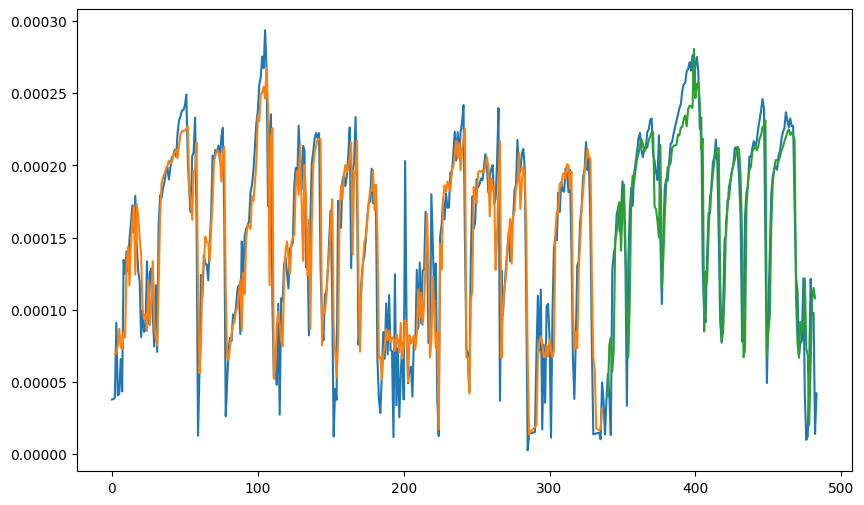

In [46]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,2]).reshape(-1,1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[TIME_STEP:len(train_predict)+TIME_STEP, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,2]).reshape(-1,1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(TIME_STEP*2)+1:len(dataset)-1, :] = test_predict

true_values = (dataset)[:,2].reshape(-1,1)
print(true_values.shape)
print(trainPredictPlot.shape)
# plot baseline and predictions
plt.clf()
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 10})
plt.plot(true_values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.savefig(f"{FOLDER_LOCATION}/{version}/predict.png")
plt.show()